In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
!pip install openpyxl
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
!pip install libpysal
!pip install esda
!pip install pysal
from esda.getisord import G_Local
from libpysal.weights import Queen
from matplotlib.colors import SymLogNorm
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from scipy.stats import ttest_ind
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm

# Specifications

In [2]:
save = False
var = 'returnPeriod_MSWEP_1d'  # Precipitation variable of interest
optimal_cluster = 'st_cluster_3_5_7'  # Cluster of interest
BASE_CPI = 313.3  # Base CPI for adjustment (e.g., 2024)

# Load Shapefiles of Interest

In [3]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Load County-Aggregated Policy Data

In [4]:
# Load aggregated sum policies by state
policies = pd.read_csv("../Local_Data/NFIP_Data/policy_total_county_averages.csv")

# Filter out rows with missing or blank values in the relevant columns
policies = policies.dropna(subset=['countyCode', 'policyCost_mean', 'totalInsurancePremiumOfThePolicy_mean'])
policies['countyCode'] = policies['countyCode'].astype(int).astype(str)
policies['countyCode'] = policies['countyCode'].apply(lambda x: str(x).zfill(5))
policies['oldest_year'] = policies['oldest_year'] -1 
policies['most_recent_year'] = policies['most_recent_year'] -1 

# Load Claims Precip Data

In [5]:
# Load claims data
claims1 = pd.read_csv("../2_Low_Return_Period/Clusters/no_percentile_filter/clustered_claims_sensitivity.csv", low_memory=False)
# Create the new field 'percentageDamageAmount'
claims1['percentageBuildingDamageAmount'] = ((claims1['buildingDamageAmount'] / claims1['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
claims1['totalClaimPaid'] = claims1['amountPaidOnBuildingClaim'].fillna(0) + claims1['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
claims1 = claims1[claims1['stateOwnedIndicator'] != True]
# Create mitigated field
claims1['mitigated'] = claims1['elevatedBuildingIndicator'] | claims1['floodproofedIndicator']

# Ensure that 'countyCode' is properly formatted as a 5-character string
claims1['countyCode'] = claims1['countyCode'].astype(int).astype(str)
claims1['countyCode'] = claims1['countyCode'].apply(lambda x: str(x).zfill(5))

# Load Risk Rating 2.0 Data

In [6]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

## Map Fips to appropriate county

In [7]:
# Read the file line by line
with open('../Local_Data/fips_codes.txt', 'r') as file:
    lines = file.readlines()

# Identify where state-level data starts and ends
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # State data starts after the "state-level" heading
    if "county-level" in line.lower():
        county_section_start = i + 2  # County data starts after the "county-level" heading
        break

# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

# Split the data into sections
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # Skip the header lines
    if "county-level" in line.lower():
        county_section_start = i + 2  # Skip the header lines
        break

state_lines = lines[state_section_start:county_section_start-2]  # State data lines
county_lines = lines[county_section_start:]  # County data line

# Parse county data
county_fips = []
county_name = []

for line in county_lines:
    line = line.strip()
    if len(line) > 12 and line[:5].isdigit():
        county_fips_code = line[:5].strip()
        county_fips_name = line[12:].strip()
        county_fips.append(county_fips_code)
        county_name.append(county_fips_name)

county_df = pd.DataFrame({
    'countyCode': county_fips,
    'County Name': county_name
})

county_df['State FIPS'] = county_df['countyCode'].str[:2]  # Extract state FIPS from the countyCode

# Merge
fips_df = county_df.merge(state_df, on='State FIPS')
fips_df['County Name'] = fips_df['County Name'].str.upper()

In [8]:
# Ensure that County and State names are fully capitalized in the aggregated_risk_policies DataFrame
aggregated_risk_policies['County'] = aggregated_risk_policies['County'].str.upper()
aggregated_risk_policies['State'] = aggregated_risk_policies['State'].str.upper()

# Merge the DataFrames
aggregated_risk_policies = aggregated_risk_policies.merge(fips_df, left_on=['County', 'State'], right_on=['County Name', 'State Name'], how='left')

# Drop unnecessary columns (optional)
aggregated_risk_policies = aggregated_risk_policies.drop(columns=['County Name', 'State Name'])

# Load Clustered Claims Data

In [9]:
# Load claims data
claims = pd.read_csv("clustered_claims_final.csv", low_memory=False)

# 1) Coerce dtypes
num_cols = ["latitude", "longitude", "adjustedClaim"]
claims[num_cols] = claims[num_cols].apply(pd.to_numeric, errors="coerce")
claims["dateOfLoss"] = pd.to_datetime(claims["dateOfLoss"], errors="coerce")
claims['countyCode'] = claims['countyCode'].astype(int).astype(str)
claims['countyCode'] = claims['countyCode'].apply(lambda x: str(x).zfill(5))

## Unclustered Claims

In [10]:
# Filter claims to only include rows where optimal_cluster == -1
filtered_claims = claims[claims[optimal_cluster] == -1].copy()
filtered_claims['countyCode'] = filtered_claims['countyCode'].astype(int).astype(str)
filtered_claims['countyCode'] = filtered_claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Group by 'countyCode' and count the number of datapoints
cluster_counts = filtered_claims.groupby('countyCode').size().reset_index(name='countUncluster')

# Merge the grouped counts with gdf_counties based on 'countyCode' and 'GEOID'
gdf_counties = gdf_counties.merge(cluster_counts, left_on='GEOID', right_on='countyCode', how='left', suffixes=('', '_drop'))

# Drop the duplicate 'countyCode_drop' column from the merge
gdf_counties.drop(columns=['countyCode_drop'], inplace=True, errors='ignore')

# Replace NaN values with 0 (for counties with no data points)
gdf_counties['countUncluster'] = gdf_counties['countUncluster'].fillna(0)

# Load Multiple Loss Properties

In [11]:
multi_loss = pd.read_csv('../Local_Data/NFIP_Data/NfipMultipleLossProperties.csv')

## Preprocess

In [12]:
# Ensure the countyCode is a string with leading zeros if needed
multi_loss = multi_loss.dropna(subset=['fipsCountyCode'])
multi_loss['fipsCountyCode'] = multi_loss['fipsCountyCode'].astype(int).astype(str)
multi_loss['fipsCountyCode'] = multi_loss['fipsCountyCode'].apply(lambda x: str(x).zfill(5))

county_multi_loss = multi_loss.groupby("fipsCountyCode").aggregate({
    'nfipRl':'sum',
    'nfipSrl':'sum',
    'fmaRl':'sum',
    'fmaSrl':'sum',
    'totalLosses':'sum',
    'primaryResidenceIndicator':'sum',
    'mitigatedIndicator':'sum',
    'insuredIndicator':'sum'}).reset_index()
county_multi_loss['Rl'] = county_multi_loss['nfipRl']+county_multi_loss['fmaRl']
county_multi_loss['Srl'] = county_multi_loss['nfipSrl']+county_multi_loss['fmaSrl']
county_multi_loss['totalMultiLossProp'] = county_multi_loss['Rl']+county_multi_loss['Srl']
# Avoid division by zero by using np.where
county_multi_loss['lossPerProp'] = np.where(county_multi_loss['totalMultiLossProp'] != 0,
                                            county_multi_loss['totalLosses'] / county_multi_loss['totalMultiLossProp'],
                                            0)

county_multi_loss['percentInsured'] = np.where(
    county_multi_loss['totalMultiLossProp'] != 0,
    (county_multi_loss['insuredIndicator'] / county_multi_loss['totalMultiLossProp'] * 100).clip(upper=100),
    0
)

county_multi_loss['percentMitigated'] = np.where(
    county_multi_loss['totalMultiLossProp'] != 0,
    (county_multi_loss['mitigatedIndicator'] / county_multi_loss['totalMultiLossProp'] * 100).clip(upper=100),
    0
)

county_multi_loss['percentPrimaryResidence'] = np.where(
    county_multi_loss['totalMultiLossProp'] != 0,
    (county_multi_loss['primaryResidenceIndicator'] / county_multi_loss['totalMultiLossProp'] * 100).clip(upper=100),
    0
)

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(county_multi_loss, left_on='GEOID', right_on='fipsCountyCode', how='left')

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Getis-Ord Hotspot Analysis

## Unclustered Claims

In [13]:
# Filter to CONUS counties (exclude AK, HI, PR, territories)
# Uses FIPS state codes: 02=AK, 15=HI, 72=PR, 60/66/69/78 = territories
exclude_states = {"02", "15", "72", "60", "66", "69", "78"}
gdf_counties = gdf_counties[~gdf_counties["STATEFP"].isin(exclude_states)].copy()

# Define spatial weights
w = Queen.from_dataframe(gdf_counties, use_index=True)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['countUncluster'] = gdf_counties['countUncluster'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['countUncluster'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_countUncluster'] = g_local.Gs
gdf_counties['Z_Scores_countUncluster'] = g_local.z_sim
gdf_counties['P_Values_countUncluster'] = g_local.p_sim

## Multiple Loss Properties

In [14]:
# Filter to CONUS counties (exclude AK, HI, PR, territories)
# Uses FIPS state codes: 02=AK, 15=HI, 72=PR, 60/66/69/78 = territories
exclude_states = {"02", "15", "72", "60", "66", "69", "78"}
gdf_counties = gdf_counties[~gdf_counties["STATEFP"].isin(exclude_states)].copy()

# Define spatial weights
w = Queen.from_dataframe(gdf_counties, use_index=True)
w.transform = 'r'  # Row-standardized weights

# Handle missing values (replace with 0 if necessary)
gdf_counties['totalMultiLossProp'] = gdf_counties['totalMultiLossProp'].fillna(0)

# Perform Getis-Ord analysis
attribute = gdf_counties['totalMultiLossProp'].values
g_local = G_Local(attribute, w)

# Add results to GeoDataFrame
gdf_counties['G_Statistic_totalMultiLossProp'] = g_local.Gs
gdf_counties['Z_Scores_totalMultiLossProp'] = g_local.z_sim
gdf_counties['P_Values_totalMultiLossProp'] = g_local.p_sim

# Aggregate Unclustered Stats

In [15]:
claims_clusters = claims

# Filter claims_cluster to only include those from 1998 to present
claims_clusters['dateOfLoss'] = pd.to_datetime(claims_clusters['dateOfLoss'])

# Define cluster group
claims_clusters['Cluster_Group'] = claims_clusters[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')
claims1['Cluster_Group'] = claims1[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')

# Group by 'optimal_cluster' and calculate medians and sizes
cluster_centers = claims_clusters.groupby(optimal_cluster).agg(
    median_latitude=('latitude', 'median'),
    median_longitude=('longitude', 'median'),
    cluster_size=('latitude', 'size'),  # Count rows in each cluster
    claim_sum=('adjustedClaim', 'sum'), # Median of the claim_sum for color mapping
    median_date=("dateOfLoss", "median") 
).reset_index()

sum_unclustered = claims_clusters[claims_clusters[optimal_cluster] == -1]['adjustedClaim'].sum()
annual_unclustered = float(sum_unclustered)/(claims_clusters['yearOfLoss'].max()-claims_clusters['yearOfLoss'].min())
claim_sum = cluster_centers['claim_sum'].sum()
average_claim_sum = float(claim_sum)/(claims_clusters['yearOfLoss'].max()-claims_clusters['yearOfLoss'].min())

# Data for the first chart
data1 = {
    "Type": ["Unclustered", "Clustered"],
    "Value": [annual_unclustered/1000000, average_claim_sum/1000000]
}
df1 = pd.DataFrame(data1)

# Plot 6

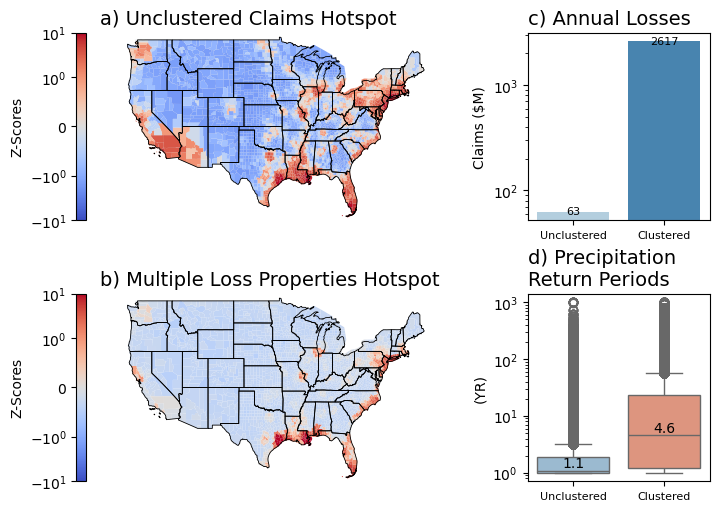

In [16]:
# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]
norm_coolwarm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)

# Create the figure with GridSpec for custom column widths
fig = plt.figure(figsize=(7.08, 5), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, width_ratios=[2, 1])  # Adjust column width ratios

# Subplot a: Uncluster Claims Hotspot
ax_a = fig.add_subplot(gs[0, 0])
ax_a.set_title('a) Unclustered Claims Hotspot', fontsize=14, loc='left')
gdf_counties.plot(
    column='Z_Scores_countUncluster', cmap='coolwarm', linewidth=0.01, ax=ax_a,
    edgecolor='0.6', norm=norm_coolwarm)
gdf_states.boundary.plot(ax=ax_a, edgecolor='black', linewidth=0.6)
ax_a.set_xlim(extent[0], extent[1])
ax_a.set_ylim(extent[2], extent[3])
ax_a.axis('off')

# Add colorbar for subplot a
sm1 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=ax_a, orientation='vertical', location='left', fraction=0.03, pad=0.04)
cbar1.set_label('Z-Scores', fontsize=10)

# Subplot b: Multiple Loss Properties Hotspot
ax_b = fig.add_subplot(gs[1, 0])
ax_b.set_title('b) Multiple Loss Properties Hotspot', fontsize=14, loc='left')
gdf_counties.plot(
    column='Z_Scores_totalMultiLossProp', linewidth=0.01, cmap='coolwarm', norm=norm_coolwarm, ax=ax_b
)
gdf_states.boundary.plot(ax=ax_b, edgecolor='black', linewidth=0.6)
ax_b.set_xlim(extent[0], extent[1])
ax_b.set_ylim(extent[2], extent[3])
ax_b.axis('off')

# Add colorbar for subplot b
sm2 = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_coolwarm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax_b, orientation='vertical', location='left', fraction=0.03, pad=0.04)
cbar2.set_label('Z-Scores', fontsize=10)

# Subplot c: Annual Losses (Bar plot)
ax_c = fig.add_subplot(gs[0, 1])
sns.barplot(ax=ax_c, data=df1, x="Type", y="Value", hue="Type", palette="Blues")
ax_c.set_title("c) Annual Losses", fontsize=14, loc='left')
ax_c.set_ylabel("Claims ($M)")
ax_c.set_xlabel("")
ax_c.set_xticks(ax_c.get_xticks())
ax_c.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)
# Set y-axis to logarithmic scale
ax_c.set_yscale('log')

# Add labels on top of the bars
for bar in ax_c.patches:
    height = bar.get_height()  # Get the height of the bar
    y_pos = height*0.9
    if height > 0:  # Avoid labeling bars with non-positive heights
        ax_c.text(
            bar.get_x() + bar.get_width() / 2,  # X position of the label
            y_pos,  # Y position of the label
            f'{height:.0f}',  # Rounded value as a string
            ha='center',  # Center align the text
            va='bottom',  # Bottom align the text
            fontsize=8  # Adjust font size
        )

# Subplot d: Clustered vs Unclustered (Box plot)
ax_d = fig.add_subplot(gs[1, 1])
sns.boxplot(
    ax=ax_d,
    x='Cluster_Group',
    y=var,
    data=claims1,
    order=['Unclustered','Clustered'],
    hue="Cluster_Group",
    palette=["#92BCD9", "#ED8D6F"]
)
ax_d.set_title("d) Precipitation\nReturn Periods", fontsize=14, loc='left')
ax_d.set_ylabel("(YR)")
ax_d.set_xlabel("")
ax_d.set_yscale('log')
ax_d.set_xticks(ax_c.get_xticks())
ax_d.set_xticklabels(ax_c.get_xticklabels(), fontsize=8)


# Add median annotations to subplot d
medians_clustered = claims1.groupby('Cluster_Group')[var].median()
for i, group in enumerate(['Unclustered','Clustered']):
    median = medians_clustered.get(group, None)
    if median is not None:
        ax_d.text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black')

if save:
    output_path = 'Plots/F6_Unclustered_Hotspot.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

# Final adjustments and show plot
plt.show()